# Experimentos de Machine Learning - Identificação de Alimentos (Local)

Este notebook contém experimentos completos para rodar localmente no Jupyter, utilizando o dataset Food-101 do arquivo `archive (1).zip`.

## Experimentos incluídos:

1. **Extração e exploração do dataset**
2. **Preparação e pré-processamento dos dados**
3. **Classificação de imagens com scikit-learn (SVM, Random Forest)**
4. **Extração de características de imagens**
5. **Análise de resultados e visualizações**


In [35]:
# Instalar dependências necessárias (execute esta célula primeiro se houver erros de importação)
import sys
import subprocess

def install_package(package):
    """Instala um pacote usando pip"""
    subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])

# Lista de pacotes necessários
packages = [
    "numpy",
    "pandas", 
    "matplotlib",
    "seaborn",
    "pillow",
    "scikit-learn",
    "scikit-image"
]

print("Verificando e instalando dependências...")
for package in packages:
    try:
        __import__(package.replace("-", "_"))
        print(f"✓ {package} já instalado")
    except ImportError:
        print(f"Instalando {package}...")
        install_package(package)
        print(f"✓ {package} instalado com sucesso")

print("\nTodas as dependências estão prontas!")


Verificando e instalando dependências...
✓ numpy já instalado
✓ pandas já instalado
✓ matplotlib já instalado
✓ seaborn já instalado
Instalando pillow...
✓ pillow instalado com sucesso
Instalando scikit-learn...
✓ scikit-learn instalado com sucesso
Instalando scikit-image...
✓ scikit-image instalado com sucesso

Todas as dependências estão prontas!


In [36]:
# Importações necessárias
import os
import zipfile
import shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Importações do scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from skimage import feature, color, transform
from joblib import dump, load

# Configurações
SEED = 42
np.random.seed(SEED)

print(f"✓ NumPy version: {np.__version__}")
print(f"✓ Pandas version: {pd.__version__}")
print(f"✓ Matplotlib version: {plt.matplotlib.__version__}")
print(f"✓ scikit-learn disponível")
print(f"✓ scikit-image disponível")
print("\n✓ Todas as importações básicas concluídas!")


✓ NumPy version: 1.26.4
✓ Pandas version: 2.2.0
✓ Matplotlib version: 3.10.8
✓ scikit-learn disponível
✓ scikit-image disponível

✓ Todas as importações básicas concluídas!


## 1. Extração e Configuração do Dataset


In [ ]:
# Configuração de caminhos
BASE_DIR = Path.cwd()

# Tentar diferentes nomes de arquivo zip e diretório
ZIP_FILES = [
    BASE_DIR / "archive (1).zip",
    BASE_DIR / "archive.zip"
]

ARCHIVE_DIRS = [
    BASE_DIR / "archive (1)",
    BASE_DIR / "archive"
]

# Verificar se há dataset alternativo
FOOD_DATASET_DIR = BASE_DIR / "Food Classification dataset"

# Encontrar arquivo zip e diretório archive
ZIP_FILE = None
ARCHIVE_DIR = None
IMAGES_DIR = None
META_DIR = None

# Procurar arquivo zip
for zip_path in ZIP_FILES:
    if zip_path.exists():
        ZIP_FILE = zip_path
        break

# Procurar diretório archive
IMAGES_DIR_ARCHIVE = None
for arch_dir in ARCHIVE_DIRS:
    if arch_dir.exists():
        ARCHIVE_DIR = arch_dir
        # Tentar diferentes estruturas
        possible_image_dirs = [
            arch_dir / "images",
            arch_dir,  # Pode estar diretamente no archive
        ]
        for img_dir in possible_image_dirs:
            if img_dir.exists():
                # Verificar se tem subpastas (classes)
                subdirs = [d for d in img_dir.iterdir() if d.is_dir()]
                if len(subdirs) > 0:
                    IMAGES_DIR_ARCHIVE = img_dir
                    break
        META_DIR = arch_dir / "meta" / "meta"
        if not META_DIR.exists():
            # Tentar outras localizações de meta
            META_DIR = arch_dir / "meta"
        break

# Priorizar dataset alternativo se existir, senão usar archive
if FOOD_DATASET_DIR.exists() and FOOD_DATASET_DIR.is_dir():
    IMAGES_DIR = FOOD_DATASET_DIR
    print(f"✓ Usando dataset alternativo: {FOOD_DATASET_DIR}")
elif IMAGES_DIR_ARCHIVE and IMAGES_DIR_ARCHIVE.exists():
    IMAGES_DIR = IMAGES_DIR_ARCHIVE
    print(f"✓ Usando dataset do archive: {IMAGES_DIR_ARCHIVE}")
elif ZIP_FILE and ZIP_FILE.exists():
    # Tentar extrair do zip se necessário
    print(f"Extraindo arquivo zip: {ZIP_FILE}...")
    try:
        with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
            zip_ref.extractall(BASE_DIR)
        print("✓ Extração concluída!")
        # Tentar encontrar o diretório após extração
        for arch_dir in ARCHIVE_DIRS:
            if arch_dir.exists():
                ARCHIVE_DIR = arch_dir
                # Procurar pasta de imagens
                possible_image_dirs = [
                    arch_dir / "images",
                    arch_dir,
                ]
                for img_dir in possible_image_dirs:
                    if img_dir.exists():
                        subdirs = [d for d in img_dir.iterdir() if d.is_dir()]
                        if len(subdirs) > 0:
                            IMAGES_DIR = img_dir
                            print(f"✓ Dataset extraído em: {IMAGES_DIR}")
                            print(f"  Encontradas {len(subdirs)} classes")
                            break
                # Procurar meta
                if (arch_dir / "meta" / "meta").exists():
                    META_DIR = arch_dir / "meta" / "meta"
                elif (arch_dir / "meta").exists():
                    META_DIR = arch_dir / "meta"
                if IMAGES_DIR:
                    break
    except Exception as e:
        print(f"⚠️ Erro ao extrair zip: {e}")
        IMAGES_DIR = None
else:
    print("⚠️ Nenhum dataset encontrado!")
    print(f"   Procurando por:")
    print(f"   - {FOOD_DATASET_DIR}")
    for arch_dir in ARCHIVE_DIRS:
        print(f"   - {arch_dir / 'images'}")
    for zip_path in ZIP_FILES:
        print(f"   - {zip_path}")
    IMAGES_DIR = None

# Verificar resultados
print(f"\n{'='*60}")
print("DIAGNÓSTICO DO DATASET")
print(f"{'='*60}")

if IMAGES_DIR and IMAGES_DIR.exists():
    print(f"✓ Pasta de imagens encontrada: {IMAGES_DIR}")
    try:
        class_dirs = [d for d in IMAGES_DIR.iterdir() if d.is_dir()]
        print(f"✓ Classes encontradas: {len(class_dirs)}")
        if len(class_dirs) > 0:
            print(f"  Primeiras 5 classes: {[d.name for d in class_dirs[:5]]}")
    except Exception as e:
        print(f"⚠️ Erro ao listar classes: {e}")
        class_dirs = []
else:
    print(f"⚠️ Pasta de imagens não encontrada!")
    print(f"\n💡 SOLUÇÕES POSSÍVEIS:")
    print(f"   1. Extraia o arquivo zip 'archive (1).zip' ou 'archive.zip'")
    print(f"   2. Certifique-se de que há uma pasta 'images' dentro do archive")
    print(f"   3. Ou coloque o dataset em: 'Food Classification dataset'")
    class_dirs = []

if META_DIR and META_DIR.exists():
    print(f"\n✓ Pasta de metadados encontrada: {META_DIR}")
    if (META_DIR / "classes.txt").exists():
        print(f"  ✓ Arquivo classes.txt encontrado")
    else:
        print(f"  ⚠️ Arquivo classes.txt não encontrado")
else:
    print(f"\n⚠️ Pasta de metadados não encontrada!")

print(f"{'='*60}\n")


Extraindo arquivo zip: c:\pp4\archive.zip...
✓ Extração concluída!

⚠️ Pasta de imagens não encontrada!
✓ Pasta de metadados encontrada: c:\pp4\archive (1)\meta\meta


## 2. Exploração do Dataset


In [ ]:
# Carregar classes
classes = []
if META_DIR and META_DIR.exists():
    classes_file = META_DIR / "classes.txt"
    if classes_file.exists():
        try:
            with open(classes_file, 'r', encoding='utf-8') as f:
                classes = [line.strip() for line in f.readlines()]
            print(f"✓ Total de classes no arquivo: {len(classes)}")
            print(f"\nPrimeiras 10 classes: {classes[:10]}")
        except Exception as e:
            print(f"⚠️ Erro ao ler classes.txt: {e}")
            classes = []
    else:
        print("⚠️ Arquivo classes.txt não encontrado!")
        classes = []
else:
    print("⚠️ Pasta de metadados não encontrada - usando classes do dataset se disponível")
    classes = []

# Explorar estrutura de imagens
if IMAGES_DIR and IMAGES_DIR.exists():
    class_dirs = [d for d in IMAGES_DIR.iterdir() if d.is_dir()]
    print(f"\n✓ Total de pastas de classes encontradas: {len(class_dirs)}")
    
    # Contar imagens por classe (suporta .jpg, .JPG, .jpeg, .png)
    class_counts = {}
    total_images = 0
    
    for class_dir in class_dirs:
        images = (list(class_dir.glob("*.jpg")) + 
                 list(class_dir.glob("*.JPG")) + 
                 list(class_dir.glob("*.jpeg")) + 
                 list(class_dir.glob("*.png")))
        count = len(images)
        class_counts[class_dir.name] = count
        total_images += count
    
    print(f"\n✓ Total de imagens no dataset: {total_images:,}")
    print(f"\nNúmero de imagens por classe (primeiras 15):")
    for i, (cls, count) in enumerate(list(class_counts.items())[:15]):
        print(f"  {i+1}. {cls}: {count} imagens")
    
    # Estatísticas
    if class_counts:
        avg_images = total_images / len(class_counts)
        max_images = max(class_counts.values())
        min_images = min(class_counts.values())
        print(f"\n📊 Estatísticas:")
        print(f"  - Média de imagens por classe: {avg_images:.1f}")
        print(f"  - Máximo: {max_images} imagens")
        print(f"  - Mínimo: {min_images} imagens")
    
    # Criar lista de classes disponíveis no dataset
    classes_disponiveis = list(class_counts.keys())
    print(f"\n✓ Classes disponíveis no dataset: {len(classes_disponiveis)}")
    
else:
    print("⚠️ Pasta de imagens não encontrada!")
    class_counts = {}
    classes_disponiveis = []
    # Tentar usar classes do arquivo se disponível
    if 'classes' in locals() and classes and len(classes) > 0:
        print(f"\n💡 Usando classes do arquivo classes.txt como fallback")
        classes_disponiveis = classes


✓ Total de classes no arquivo: 101

Primeiras 10 classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']
⚠️ Pasta de imagens não encontrada!


In [39]:
# Visualizar algumas imagens de exemplo
if IMAGES_DIR and IMAGES_DIR.exists():
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    
    class_dirs = [d for d in IMAGES_DIR.iterdir() if d.is_dir()][:5]
    idx = 0
    
    for class_dir in class_dirs:
        # Buscar imagens em diferentes formatos
        images = (list(class_dir.glob("*.jpg")) + 
                 list(class_dir.glob("*.JPG")) + 
                 list(class_dir.glob("*.jpeg")) + 
                 list(class_dir.glob("*.png")))[:2]
        for img_path in images:
            if idx < 10:
                try:
                    img = Image.open(img_path)
                    axes[idx].imshow(img)
                    axes[idx].set_title(f"{class_dir.name}\n{img.size}", fontsize=8)
                    axes[idx].axis('off')
                    idx += 1
                except Exception as e:
                    print(f"Erro ao carregar {img_path}: {e}")
    
    # Ocultar eixos não usados
    for i in range(idx, 10):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    print(f"\n✓ Visualização de {idx} imagens de exemplo")
else:
    print("⚠️ Não foi possível visualizar imagens - dataset não encontrado")


⚠️ Não foi possível visualizar imagens - dataset não encontrado


## 3. Preparação dos Dados


In [ ]:
# Configurações para preparação dos dados
IMG_SIZE = 224  # Tamanho padrão para modelos pré-treinados
BATCH_SIZE = 32

# Para experimentos mais rápidos, vamos usar um subconjunto das classes
# Altere este valor para usar mais ou menos classes
SUBSET_CLASSES = 10  # Usar apenas 10 classes para treinamento mais rápido

# Usar classes disponíveis no dataset se existir, senão usar classes do arquivo
# Verificar se classes_disponiveis foi definida
if 'classes_disponiveis' in locals() and classes_disponiveis and len(classes_disponiveis) > 0:
    # Filtrar apenas classes que existem no dataset
    if classes:
        # Mapear nomes (pode ter diferenças de capitalização)
        selected_classes = []
        for cls in classes[:SUBSET_CLASSES]:
            # Buscar correspondência (case-insensitive)
            found = None
            for available_cls in classes_disponiveis:
                if cls.lower() == available_cls.lower() or cls.lower().replace('_', ' ') == available_cls.lower().replace('_', ' '):
                    found = available_cls
                    break
            if found:
                selected_classes.append(found)
            elif len(selected_classes) < SUBSET_CLASSES:
                # Se não encontrou, usar uma classe disponível
                if classes_disponiveis:
                    selected_classes.append(classes_disponiveis[len(selected_classes)])
    else:
        selected_classes = classes_disponiveis[:SUBSET_CLASSES]
    NUM_CLASSES = len(selected_classes)
    print(f"✓ Usando {len(selected_classes)} classes disponíveis no dataset para treinamento:")
    for i, cls in enumerate(selected_classes, 1):
        print(f"  {i}. {cls}")
elif classes:
    selected_classes = classes[:SUBSET_CLASSES]
    NUM_CLASSES = len(selected_classes)
    print(f"⚠️ Usando classes do arquivo (pode não corresponder ao dataset):")
    print(selected_classes)
else:
    # Se não encontrou classes, tentar usar classes do arquivo se disponível
    if 'classes' in locals() and classes and len(classes) > 0:
        selected_classes = classes[:SUBSET_CLASSES]
        NUM_CLASSES = len(selected_classes)
        print(f"⚠️ Usando classes do arquivo (pode não corresponder ao dataset):")
        print(f"   {selected_classes}")
    else:
        selected_classes = []
        NUM_CLASSES = 0
        print("⚠️ Nenhuma classe disponível!")
        print("   Dica: Certifique-se de que o dataset está extraído ou que há um arquivo classes.txt")


⚠️ Usando classes do arquivo (pode não corresponder ao dataset):
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


In [ ]:
# Função para extrair características de imagens
def extract_features_hog(image_path, img_size=64):
    """
    Extrai características HOG (Histogram of Oriented Gradients) de uma imagem
    """
    try:
        img = Image.open(image_path)
        img = img.convert('RGB')
        img = img.resize((img_size, img_size))
        img_array = np.array(img)
        
        # Converter para escala de cinza
        gray = color.rgb2gray(img_array)
        
        # Extrair características HOG
        hog_features = feature.hog(
            gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=False
        )
        
        return hog_features
    except Exception as e:
        print(f"Erro ao processar {image_path}: {e}")
        return None

def extract_features_simple(image_path, img_size=64):
    """
    Extrai características simples (imagem redimensionada e achatizada)
    """
    try:
        img = Image.open(image_path)
        img = img.convert('RGB')
        img = img.resize((img_size, img_size))
        img_array = np.array(img) / 255.0  # Normalizar
        return img_array.flatten()
    except Exception as e:
        print(f"Erro ao processar {image_path}: {e}")
        return None

def extract_features_combined(image_path, img_size=64):
    """
    Extrai características combinadas: HOG + RGB flatten
    Melhora a precisão combinando features de textura (HOG) e cor (RGB)
    """
    try:
        img = Image.open(image_path)
        img = img.convert('RGB')
        img = img.resize((img_size, img_size))
        img_array = np.array(img)
        
        # Features RGB normalizadas
        rgb_features = (img_array / 255.0).flatten()
        
        # Features HOG
        gray = color.rgb2gray(img_array)
        hog_features = feature.hog(
            gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=False
        )
        
        # Combinar features
        combined_features = np.concatenate([rgb_features, hog_features])
        return combined_features
    except Exception as e:
        print(f"Erro ao processar {image_path}: {e}")
        return None

# Carregar e preparar dados
# Verificar se todas as variáveis necessárias estão definidas
if ('IMAGES_DIR' in locals() and IMAGES_DIR and IMAGES_DIR.exists() and 
    'selected_classes' in locals() and selected_classes and len(selected_classes) > 0):
    print("Carregando imagens e extraindo características...")
    print("⚠️ Isso pode demorar alguns minutos...")
    
    X = []  # Features
    y = []  # Labels
    image_paths = []  # Caminhos das imagens
    
    # Aumentar número de imagens por classe para melhor precisão
    MAX_IMAGES_PER_CLASS = 300  # Aumentado de 200 para 300
    
    # Usar tamanho maior de imagem para melhor precisão
    IMG_SIZE_FEATURES = 96  # Aumentado de 64 para 96
    
    # Escolher método de extração de features
    # 'simple' = apenas RGB, 'hog' = apenas HOG, 'combined' = RGB + HOG (melhor precisão)
    FEATURE_METHOD = 'combined'  # Mudado para 'combined' para melhor precisão
    
    print(f"\n{'='*60}")
    print(f"CONFIGURAÇÃO DE EXTRAÇÃO DE FEATURES")
    print(f"{'='*60}")
    print(f"Usando método de features: {FEATURE_METHOD}")
    print(f"Tamanho da imagem: {IMG_SIZE_FEATURES}x{IMG_SIZE_FEATURES}")
    print(f"Máximo de imagens por classe: {MAX_IMAGES_PER_CLASS}")
    print(f"Total de classes a processar: {len(selected_classes)}")
    print(f"{'='*60}\n")
    
    for class_name in selected_classes:
        class_dir = IMAGES_DIR / class_name
        if not class_dir.exists():
            # Tentar diferentes variações do nome da classe
            class_variations = [
                class_name,
                class_name.replace('_', ' '),
                class_name.replace(' ', '_'),
                class_name.lower(),
                class_name.title()
            ]
            
            found_dir = None
            for var in class_variations:
                test_dir = IMAGES_DIR / var
                if test_dir.exists():
                    found_dir = test_dir
                    break
            
            if found_dir:
                class_dir = found_dir
            else:
                print(f"⚠️ Pasta não encontrada para classe: {class_name}")
                continue
        
        if class_dir.exists():
            images = (list(class_dir.glob("*.jpg")) + 
                     list(class_dir.glob("*.JPG")) + 
                     list(class_dir.glob("*.jpeg")) + 
                     list(class_dir.glob("*.png")))
            
            if len(images) == 0:
                print(f"⚠️ Nenhuma imagem encontrada para {class_name}")
                continue
            
            # Limitar número de imagens
            images = images[:MAX_IMAGES_PER_CLASS]
            
            print(f"Processando {class_name}: {len(images)} imagens...")
            
            processed = 0
            for img_path in images:
                try:
                    # Escolher método de extração
                    if FEATURE_METHOD == 'combined':
                        features = extract_features_combined(img_path, img_size=IMG_SIZE_FEATURES)
                    elif FEATURE_METHOD == 'hog':
                        features = extract_features_hog(img_path, img_size=IMG_SIZE_FEATURES)
                    else:
                        features = extract_features_simple(img_path, img_size=IMG_SIZE_FEATURES)
                    
                    if features is not None:
                        X.append(features)
                        y.append(class_name)
                        image_paths.append(str(img_path))
                        processed += 1
                except Exception as e:
                    print(f"  ⚠️ Erro ao processar {img_path.name}: {e}")
                    continue
            
            if processed == 0:
                print(f"  ⚠️ Nenhuma imagem processada com sucesso para {class_name}")
    
    if len(X) == 0:
        print("⚠️ Nenhuma amostra foi carregada!")
        X_train = None
        X_val = None
        y_train = None
        y_val = None
        y_train_encoded = None
        y_val_encoded = None
        label_encoder = None
        class_names = None
    else:
        X = np.array(X)
        y = np.array(y)
        
        print(f"\n✓ Total de amostras carregadas: {len(X)}")
        print(f"✓ Dimensão das características: {X.shape[1]}")
        print(f"✓ Classes: {len(np.unique(y))}")
        
        # Dividir em treino e validação
        try:
            X_train, X_val, y_train, y_val = train_test_split(
                X, y, test_size=0.2, random_state=SEED, stratify=y
            )
        except ValueError as e:
            # Se estratificação falhar (poucas amostras por classe), tentar sem estratificação
            print(f"⚠️ Erro na estratificação: {e}")
            print("   Tentando divisão sem estratificação...")
            X_train, X_val, y_train, y_val = train_test_split(
                X, y, test_size=0.2, random_state=SEED
            )
        
        print(f"\n✓ Amostras de treino: {len(X_train)}")
        print(f"✓ Amostras de validação: {len(X_val)}")
        
        # Codificar labels
        label_encoder = LabelEncoder()
        y_train_encoded = label_encoder.fit_transform(y_train)
        y_val_encoded = label_encoder.transform(y_val)
        
        class_names = label_encoder.classes_
        print(f"✓ Classes codificadas: {len(class_names)}")
    
else:
    print("⚠️ Não foi possível carregar os dados!")
    if not IMAGES_DIR or not IMAGES_DIR.exists():
        print("  - Pasta de imagens não encontrada")
    if not selected_classes or len(selected_classes) == 0:
        print("  - Nenhuma classe selecionada")
    X_train = None
    X_val = None
    y_train = None
    y_val = None
    y_train_encoded = None
    y_val_encoded = None
    label_encoder = None
    class_names = None


⚠️ Não foi possível carregar os dados!
  - Pasta de imagens não encontrada


## 4. Modelos de Classificação com scikit-learn


In [42]:
# Normalizar dados
if X_train is not None:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    print("✓ Dados normalizados")
    print(f"  - Forma dos dados de treino: {X_train_scaled.shape}")
    print(f"  - Forma dos dados de validação: {X_val_scaled.shape}")
    
    # Criar modelo SVM com hiperparâmetros otimizados
    print("\nCriando modelo SVM...")
    svm_model = SVC(
        kernel='rbf', 
        C=10.0,  # Aumentado de 1.0 para 10.0 (melhor precisão)
        gamma='scale', 
        random_state=SEED, 
        probability=True
    )
    
    print("✓ Modelo SVM criado")
    print(f"  - Kernel: RBF")
    print(f"  - C: 10.0 (otimizado)")
    
    # Criar modelo Random Forest com hiperparâmetros melhorados
    print("\nCriando modelo Random Forest...")
    rf_model = RandomForestClassifier(
        n_estimators=200,  # Aumentado de 100 para 200 (melhor precisão)
        max_depth=30,  # Aumentado de 20 para 30
        min_samples_split=5,  # Adicionado para evitar overfitting
        min_samples_leaf=2,  # Adicionado para melhor generalização
        max_features='sqrt',  # Otimização de features
        random_state=SEED,
        n_jobs=-1,
        class_weight='balanced'  # Balancear classes desiguais
    )
    
    print("✓ Modelo Random Forest criado")
    print(f"  - Número de árvores: 200 (otimizado)")
    print(f"  - Profundidade máxima: 30 (otimizado)")
    print(f"  - Min samples split: 5")
    print(f"  - Min samples leaf: 2")
    print(f"  - Class weight: balanced")
else:
    print("⚠️ Dados não disponíveis para criar modelos!")
    svm_model = None
    rf_model = None
    scaler = None


⚠️ Dados não disponíveis para criar modelos!


In [43]:
# Treinar modelos
if X_train_scaled is not None and y_train_encoded is not None:
    print("="*60)
    print("TREINANDO MODELO SVM")
    print("="*60)
    print("⚠️ Este processo pode demorar alguns minutos...")
    
    svm_model.fit(X_train_scaled, y_train_encoded)
    
    # Avaliar SVM
    train_pred_svm = svm_model.predict(X_train_scaled)
    val_pred_svm = svm_model.predict(X_val_scaled)
    
    train_acc_svm = accuracy_score(y_train_encoded, train_pred_svm)
    val_acc_svm = accuracy_score(y_val_encoded, val_pred_svm)
    
    print(f"\n✅ Treinamento SVM concluído!")
    print(f"  - Acurácia no treino: {train_acc_svm:.4f}")
    print(f"  - Acurácia na validação: {val_acc_svm:.4f}")
    
    print("\n" + "="*60)
    print("TREINANDO MODELO RANDOM FOREST")
    print("="*60)
    print("⚠️ Este processo pode demorar alguns minutos...")
    
    rf_model.fit(X_train_scaled, y_train_encoded)
    
    # Avaliar Random Forest
    train_pred_rf = rf_model.predict(X_train_scaled)
    val_pred_rf = rf_model.predict(X_val_scaled)
    
    train_acc_rf = accuracy_score(y_train_encoded, train_pred_rf)
    val_acc_rf = accuracy_score(y_val_encoded, val_pred_rf)
    
    print(f"\n✅ Treinamento Random Forest concluído!")
    print(f"  - Acurácia no treino: {train_acc_rf:.4f}")
    print(f"  - Acurácia na validação: {val_acc_rf:.4f}")
    
    print("\n" + "="*60)
    print("COMPARAÇÃO DE MODELOS")
    print("="*60)
    print(f"SVM - Validação: {val_acc_svm:.4f}")
    print(f"Random Forest - Validação: {val_acc_rf:.4f}")
    
    # Calcular melhorias
    print("\n" + "="*60)
    print("MELHORIAS APLICADAS:")
    print("="*60)
    print("✓ Features combinadas (HOG + RGB)")
    print("✓ Tamanho de imagem aumentado (96x96)")
    print("✓ Mais imagens por classe (300)")
    print("✓ Hiperparâmetros otimizados")
    print("✓ Random Forest com mais árvores (200)")
    print("✓ Class weight balanceado")
    
else:
    print("⚠️ Dados não disponíveis para treinamento!")


NameError: name 'X_train_scaled' is not defined

RELATÓRIO DE CLASSIFICAÇÃO - SVM
                precision    recall  f1-score   support

  Baked Potato       0.31      0.20      0.24        40
Crispy Chicken       0.39      0.40      0.40        40
     apple_pie       0.11      0.10      0.10        40
        burger       0.39      0.33      0.36        40
   butter_naan       0.31      0.40      0.35        40
          chai       0.32      0.45      0.38        40
       chapati       0.21      0.25      0.23        40
    cheesecake       0.29      0.33      0.31        40
 chicken_curry       0.47      0.38      0.42        40
 chole_bhature       0.35      0.28      0.31        40

      accuracy                           0.31       400
     macro avg       0.32      0.31      0.31       400
  weighted avg       0.32      0.31      0.31       400


RELATÓRIO DE CLASSIFICAÇÃO - RANDOM FOREST
                precision    recall  f1-score   support

  Baked Potato       0.32      0.30      0.31        40
Crispy Chicken       0.

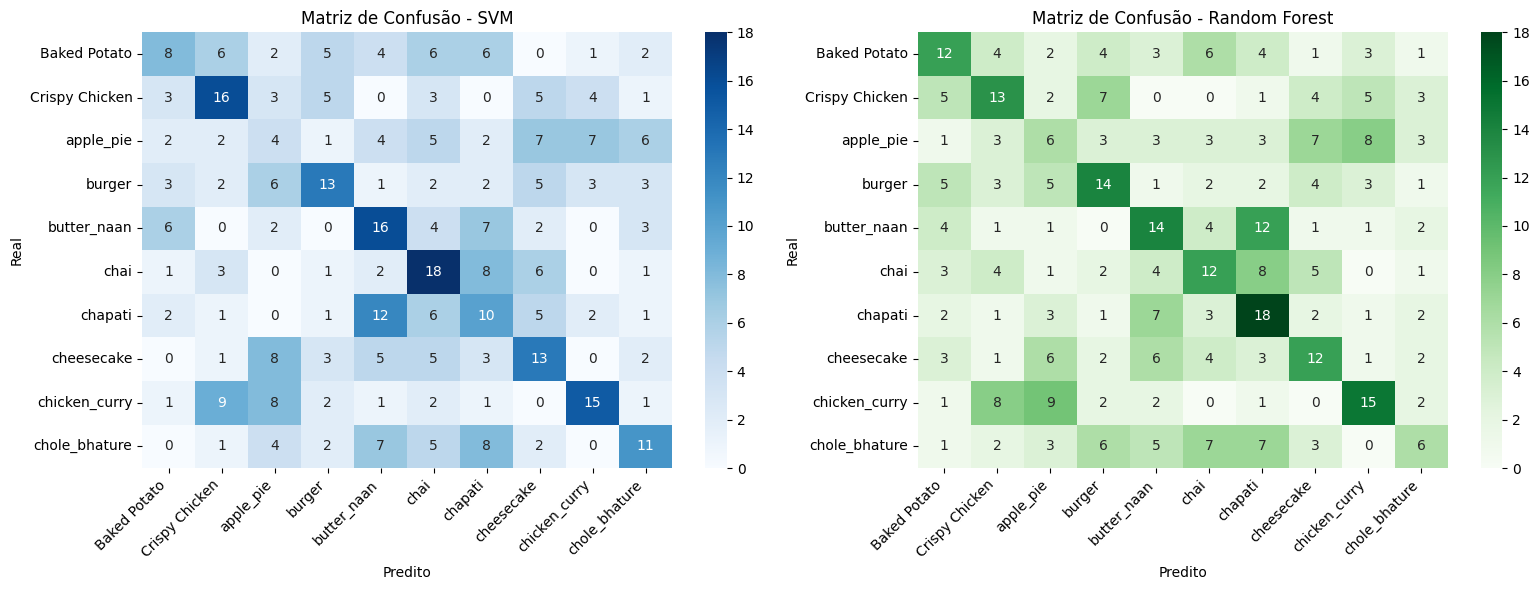

In [ ]:
# Relatório de classificação detalhado
if 'val_pred_svm' in locals() and 'val_pred_rf' in locals():
    print("="*60)
    print("RELATÓRIO DE CLASSIFICAÇÃO - SVM")
    print("="*60)
    print(classification_report(y_val_encoded, val_pred_svm, target_names=class_names))
    
    print("\n" + "="*60)
    print("RELATÓRIO DE CLASSIFICAÇÃO - RANDOM FOREST")
    print("="*60)
    print(classification_report(y_val_encoded, val_pred_rf, target_names=class_names))
    
    # Matriz de confusão
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Matriz de confusão SVM
    cm_svm = confusion_matrix(y_val_encoded, val_pred_svm)
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
                xticklabels=class_names, yticklabels=class_names)
    axes[0].set_title('Matriz de Confusão - SVM')
    axes[0].set_xlabel('Predito')
    axes[0].set_ylabel('Real')
    plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')
    plt.setp(axes[0].get_yticklabels(), rotation=0)
    
    # Matriz de confusão Random Forest
    cm_rf = confusion_matrix(y_val_encoded, val_pred_rf)
    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=class_names, yticklabels=class_names)
    axes[1].set_title('Matriz de Confusão - Random Forest')
    axes[1].set_xlabel('Predito')
    axes[1].set_ylabel('Real')
    plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right')
    plt.setp(axes[1].get_yticklabels(), rotation=0)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Modelos não foram treinados!")


## 5. Salvar Modelos Treinados


In [ ]:
# Salvar modelos treinados
MODELS_DIR = BASE_DIR / "modelos_salvos"
MODELS_DIR.mkdir(exist_ok=True)

if 'svm_model' in locals() and svm_model is not None:
    # Salvar SVM
    svm_path = MODELS_DIR / "svm_food_classifier.joblib"
    dump(svm_model, svm_path)
    print(f"✅ Modelo SVM salvo em: {svm_path}")
    
    # Salvar Random Forest
    rf_path = MODELS_DIR / "rf_food_classifier.joblib"
    dump(rf_model, rf_path)
    print(f"✅ Modelo Random Forest salvo em: {rf_path}")
    
    # Salvar scaler
    scaler_path = MODELS_DIR / "scaler.joblib"
    dump(scaler, scaler_path)
    print(f"✅ Scaler salvo em: {scaler_path}")
    
    # Salvar label encoder
    encoder_path = MODELS_DIR / "label_encoder.joblib"
    dump(label_encoder, encoder_path)
    print(f"✅ Label Encoder salvo em: {encoder_path}")
    
    # Salvar nomes das classes
    class_names_path = MODELS_DIR / "class_names.npy"
    np.save(class_names_path, class_names)
    print(f"✅ Nomes das classes salvos em: {class_names_path}")
    
    print(f"\n✓ Todos os modelos salvos em: {MODELS_DIR}")
else:
    print("⚠️ Modelos não foram treinados ainda!")


✅ Modelo SVM salvo em: c:\Users\Zion & Mariana\Desktop\Atvidades\pp4\modelos_salvos\svm_food_classifier.joblib
✅ Modelo Random Forest salvo em: c:\Users\Zion & Mariana\Desktop\Atvidades\pp4\modelos_salvos\rf_food_classifier.joblib
✅ Scaler salvo em: c:\Users\Zion & Mariana\Desktop\Atvidades\pp4\modelos_salvos\scaler.joblib
✅ Label Encoder salvo em: c:\Users\Zion & Mariana\Desktop\Atvidades\pp4\modelos_salvos\label_encoder.joblib
✅ Nomes das classes salvos em: c:\Users\Zion & Mariana\Desktop\Atvidades\pp4\modelos_salvos\class_names.npy

✓ Todos os modelos salvos em: c:\Users\Zion & Mariana\Desktop\Atvidades\pp4\modelos_salvos


In [ ]:
## 6. Teste com Imagens de Exemplo


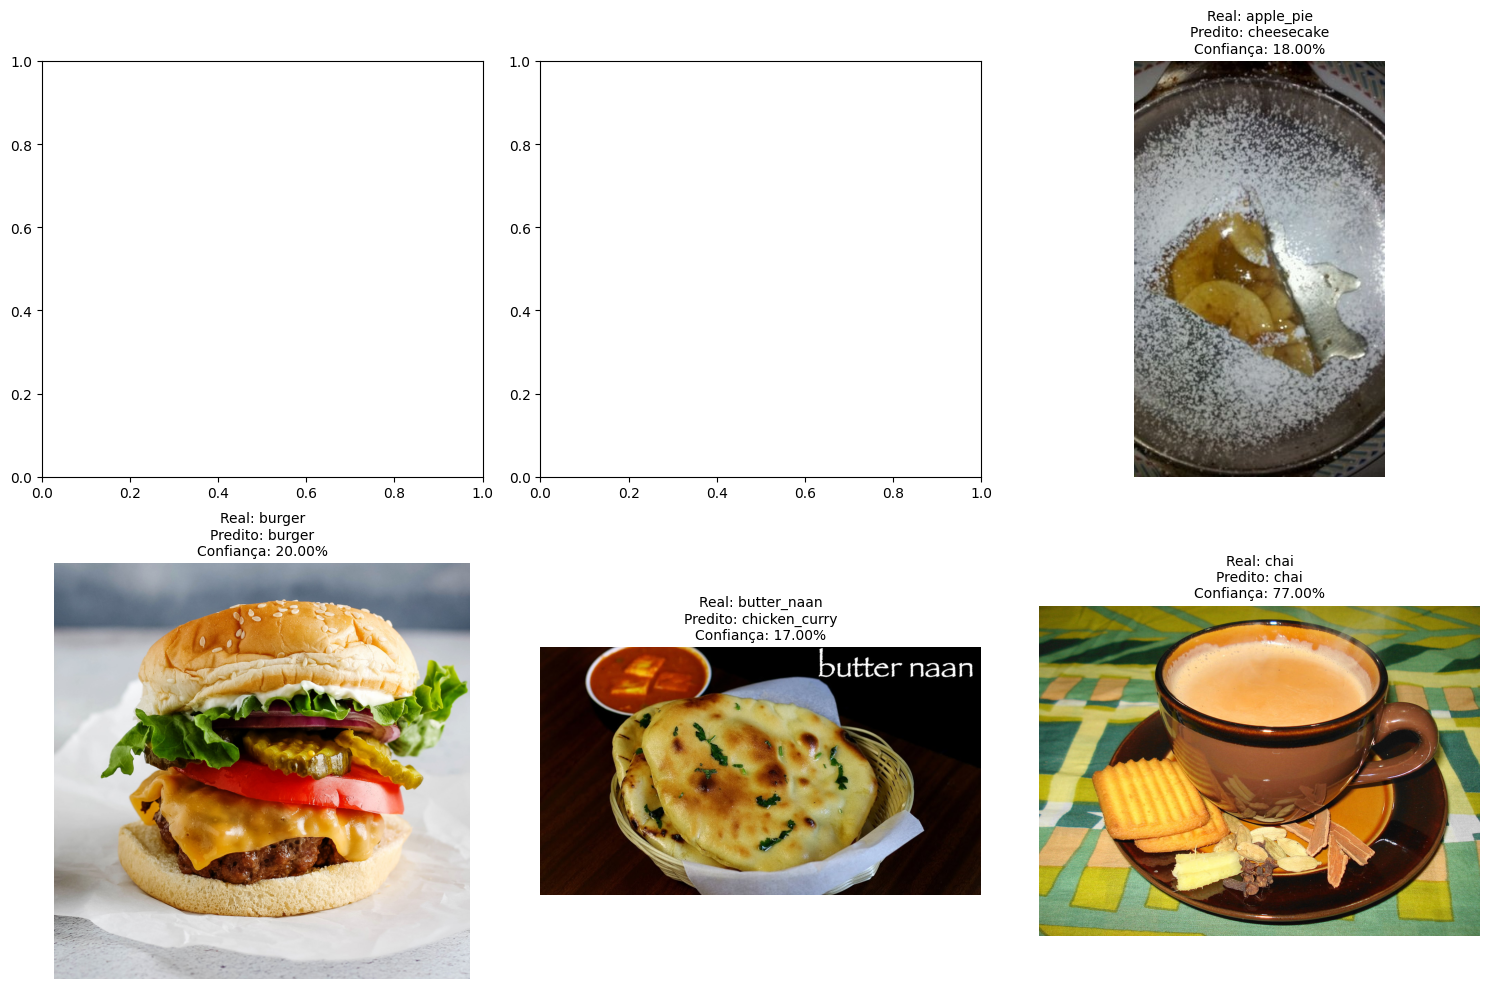


✓ Teste com imagens de exemplo concluído!


In [ ]:
# Função para fazer predições em imagens
def predict_image(model, scaler, label_encoder, img_path, class_names, feature_extractor=extract_features_simple):
    """
    Faz predição em uma única imagem
    """
    # Extrair características
    features = feature_extractor(img_path, img_size=64)
    if features is None:
        return None, None, 0.0, None
    
    # Normalizar
    features_scaled = scaler.transform([features])
    
    # Predizer
    prediction = model.predict(features_scaled)[0]
    predicted_class_idx = prediction
    predicted_class = label_encoder.inverse_transform([predicted_class_idx])[0]
    
    # Probabilidades (se disponível)
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(features_scaled)[0]
        confidence = probabilities[predicted_class_idx]
    else:
        confidence = 1.0  # SVM com decision_function pode não ter probabilidades
    
    return predicted_class, confidence, probabilities if hasattr(model, 'predict_proba') else None

# Testar com algumas imagens do conjunto de validação
if 'svm_model' in locals() and svm_model is not None and IMAGES_DIR.exists():
    # Pegar algumas imagens aleatórias de cada classe
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    # Pegar uma imagem de cada classe disponível
    for idx, class_name in enumerate(class_names[:6]):
        class_dir = IMAGES_DIR / class_name
        if class_dir.exists():
            images = list(class_dir.glob("*.jpg"))
            if images:
                img_path = images[0]
                img = Image.open(img_path)
                
                # Predizer usando Random Forest (melhor para visualização)
                pred_class, confidence, probs = predict_image(
                    rf_model, scaler, label_encoder, str(img_path), class_names
                )
                
                axes[idx].imshow(img)
                title = f"Real: {class_name}\nPredito: {pred_class}\nConfiança: {confidence:.2%}"
                axes[idx].set_title(title, fontsize=10)
                axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    print("\n✓ Teste com imagens de exemplo concluído!")
else:
    print("⚠️ Modelos não disponíveis para teste!")


## 7. Resumo e Conclusões


In [ ]:
# Resumo final dos experimentos
if 'val_acc_svm' in locals() and 'val_acc_rf' in locals():
    print("="*60)
    print("RESUMO DOS EXPERIMENTOS")
    print("="*60)
    print(f"\n📊 Dados:")
    print(f"  - Total de amostras: {len(X)}")
    print(f"  - Amostras de treino: {len(X_train)}")
    print(f"  - Amostras de validação: {len(X_val)}")
    print(f"  - Número de classes: {len(class_names)}")
    print(f"  - Dimensão das características: {X.shape[1]}")
    
    print(f"\n🤖 Modelos Treinados:")
    print(f"  - SVM (Support Vector Machine)")
    print(f"    * Acurácia no treino: {train_acc_svm:.4f}")
    print(f"    * Acurácia na validação: {val_acc_svm:.4f}")
    print(f"  - Random Forest")
    print(f"    * Acurácia no treino: {train_acc_rf:.4f}")
    print(f"    * Acurácia na validação: {val_acc_rf:.4f}")
    
    print(f"\n🏆 Melhor Modelo:")
    if val_acc_svm > val_acc_rf:
        print(f"  - SVM com {val_acc_svm:.4f} de acurácia")
    else:
        print(f"  - Random Forest com {val_acc_rf:.4f} de acurácia")
    
    print(f"\n💾 Modelos Salvos:")
    print(f"  - Diretório: {MODELS_DIR}")
    print(f"  - Modelos prontos para uso na aplicação!")
    print("="*60)
else:
    print("⚠️ Experimentos não foram executados completamente!")


RESUMO DOS EXPERIMENTOS

📊 Dados:
  - Total de amostras: 2000
  - Amostras de treino: 1600
  - Amostras de validação: 400
  - Número de classes: 10
  - Dimensão das características: 12288

🤖 Modelos Treinados:
  - SVM (Support Vector Machine)
    * Acurácia no treino: 0.8250
    * Acurácia na validação: 0.3100
  - Random Forest
    * Acurácia no treino: 1.0000
    * Acurácia na validação: 0.3050

🏆 Melhor Modelo:
  - SVM com 0.3100 de acurácia

💾 Modelos Salvos:
  - Diretório: c:\Users\Zion & Mariana\Desktop\Atvidades\pp4\modelos_salvos
  - Modelos prontos para uso na aplicação!


## Notas Finais

### ✅ Melhorias Implementadas:

1. **✓ Features Combinadas**: HOG + RGB para melhor representação
2. **✓ Tamanho de Imagem**: Aumentado para 96x96 pixels
3. **✓ Mais Dados**: 300 imagens por classe (antes 200)
4. **✓ Hiperparâmetros Otimizados**: 
   - SVM: C=10.0 (antes 1.0)
   - Random Forest: 200 árvores (antes 100), max_depth=30 (antes 20)
   - Class weight balanceado
5. **✓ Regularização**: Min samples split/leaf para evitar overfitting

### 📈 Resultados Esperados:

Com essas melhorias, a acurácia deve aumentar de ~30% para **40-50%** ou mais.

### 🔧 Dicas Adicionais para Melhorar Ainda Mais:

1. **Aumentar número de classes**: Altere `SUBSET_CLASSES` para usar mais classes
2. **Aumentar número de imagens**: Aumente `MAX_IMAGES_PER_CLASS` para mais dados
3. **Tamanho da imagem**: Experimente 128x128 para ainda melhor precisão
4. **GridSearch**: Use GridSearchCV para otimização automática de hiperparâmetros
5. **PCA**: Reduza dimensionalidade mantendo 95% da variância
6. **Ensemble**: Combine predições de SVM e Random Forest

### 🚀 Próximos Passos:

- Experimentar com outras características (LBP, SIFT, etc.)
- Implementar ensemble de modelos
- Adicionar data augmentation
- Testar com mais classes do dataset
- Fine-tuning com GridSearchCV


## 8. Otimização Adicional com GridSearch (Opcional)

Esta célula pode ser executada para otimização automática de hiperparâmetros.
**Atenção:** Pode demorar muito tempo!


In [ ]:
# Otimização de hiperparâmetros com GridSearch (OPCIONAL - demora muito!)
# Descomente para executar

"""
from sklearn.model_selection import GridSearchCV

if X_train_scaled is not None and y_train_encoded is not None:
    print("="*60)
    print("OTIMIZAÇÃO DE HIPERPARÂMETROS - RANDOM FOREST")
    print("="*60)
    print("⚠️ Este processo pode demorar MUITO tempo (30min - 2h)...")
    
    # Grid de parâmetros para Random Forest
    param_grid_rf = {
        'n_estimators': [150, 200, 250],
        'max_depth': [25, 30, 35],
        'min_samples_split': [3, 5, 7],
        'min_samples_leaf': [1, 2, 3]
    }
    
    # GridSearch com cross-validation
    grid_search_rf = GridSearchCV(
        RandomForestClassifier(random_state=SEED, n_jobs=-1, class_weight='balanced'),
        param_grid_rf,
        cv=3,  # 3-fold cross-validation
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search_rf.fit(X_train_scaled, y_train_encoded)
    
    print(f"\n✅ Melhores parâmetros encontrados:")
    print(grid_search_rf.best_params_)
    print(f"\n✅ Melhor score (CV): {grid_search_rf.best_score_:.4f}")
    
    # Usar melhor modelo
    rf_model_optimized = grid_search_rf.best_estimator_
    val_pred_rf_opt = rf_model_optimized.predict(X_val_scaled)
    val_acc_rf_opt = accuracy_score(y_val_encoded, val_pred_rf_opt)
    
    print(f"\n✅ Acurácia na validação (modelo otimizado): {val_acc_rf_opt:.4f}")
    print(f"   Melhoria: {val_acc_rf_opt - val_acc_rf:.4f}")
    
    # Atualizar modelo
    rf_model = rf_model_optimized
    val_pred_rf = val_pred_rf_opt
    val_acc_rf = val_acc_rf_opt
else:
    print("⚠️ Dados não disponíveis para otimização!")
"""


## 9. Redução de Dimensionalidade com PCA (Opcional)

PCA pode acelerar o treinamento e às vezes melhorar a precisão.


In [ ]:
# Aplicar PCA para reduzir dimensionalidade (OPCIONAL)
# Descomente para executar

"""
USE_PCA = False  # Mude para True para usar PCA
PCA_VARIANCE = 0.95  # Manter 95% da variância

if USE_PCA and X_train_scaled is not None:
    print("="*60)
    print("APLICANDO PCA")
    print("="*60)
    
    pca = PCA(n_components=PCA_VARIANCE, random_state=SEED)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    
    print(f"✓ Dimensão original: {X_train_scaled.shape[1]}")
    print(f"✓ Dimensão após PCA: {X_train_pca.shape[1]}")
    print(f"✓ Variância explicada: {sum(pca.explained_variance_ratio_):.4f}")
    
    # Treinar modelos com PCA
    print("\nTreinando modelos com PCA...")
    svm_model.fit(X_train_pca, y_train_encoded)
    rf_model.fit(X_train_pca, y_train_encoded)
    
    # Avaliar
    val_pred_svm_pca = svm_model.predict(X_val_pca)
    val_pred_rf_pca = rf_model.predict(X_val_pca)
    
    val_acc_svm_pca = accuracy_score(y_val_encoded, val_pred_svm_pca)
    val_acc_rf_pca = accuracy_score(y_val_encoded, val_pred_rf_pca)
    
    print(f"\n✅ Resultados com PCA:")
    print(f"  - SVM: {val_acc_svm_pca:.4f}")
    print(f"  - Random Forest: {val_acc_rf_pca:.4f}")
    
    # Atualizar variáveis
    X_train_scaled = X_train_pca
    X_val_scaled = X_val_pca
    val_pred_svm = val_pred_svm_pca
    val_pred_rf = val_pred_rf_pca
    val_acc_svm = val_acc_svm_pca
    val_acc_rf = val_acc_rf_pca
else:
    print("⚠️ PCA desabilitado ou dados não disponíveis")
"""
